
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load particular Environment Adapter
from example.adapter.CartPoleEnvironmentAdapter import CartPoleEnvironmentAdapter

# Load Metrics
from example.metrics.CartPoleMetrics import _cartpole_metrics, _mean_reliable_classifier_specificity

# Load Plotting Wrappers
from example.metrics.CartPolePlottingWrapper import \
    parse_metrics_to_df, \
    plot_cartpole_performance, \
    plot_average_cartpole_performance

# Load environments
import gym

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
CLASSIFIER_LENGTH = 4
NUMBER_OF_POSSIBLE_ACTIONS = 2
CARTPOLE = "CartPole-v0" #CartPole-v1 goes up to 500 episodes

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 500
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 0

## Environment - CartPole

In [3]:
# Initialize environment
CartPole = gym.make(CARTPOLE)
# Reset it, by putting an agent into random position
state = CartPole.reset()

## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=CartPoleEnvironmentAdapter,
    user_metrics_collector_fcn=_cartpole_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(CartPole, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 5.36 s, sys: 21.9 ms, total: 5.38 s
Wall time: 5.44 s


### Performance

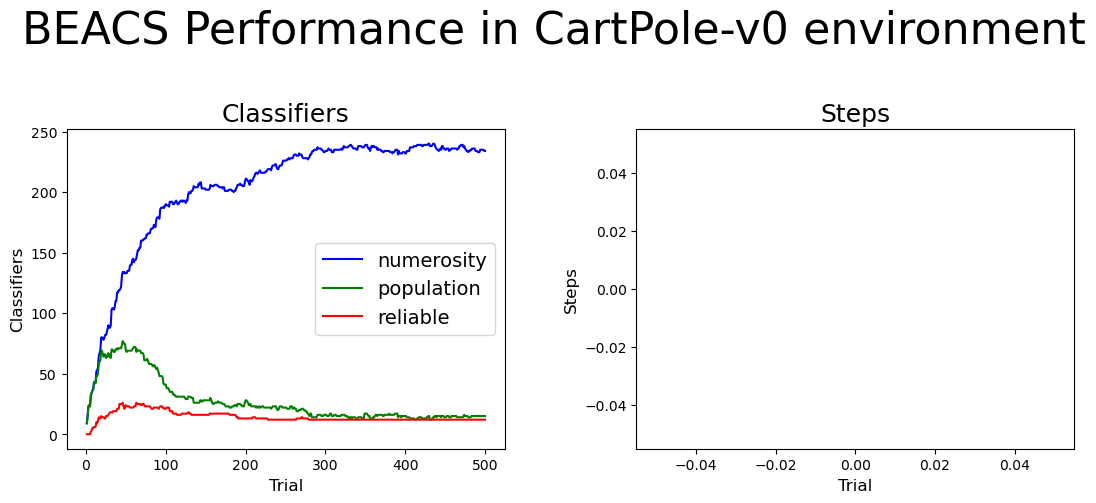

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_cartpole_performance(agent_explore, CartPole, metrics_df, cfg_explore, CARTPOLE, metrics_trial_frequency_explore, None)

In [6]:
print(_cartpole_metrics(population_explore, CartPole))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, CartPole))

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_cartpole_metrics(population_explore, CartPole))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, CartPole))

{'population': 15, 'numerosity': 234, 'reliable': 12}
Mean reliable population specifity is  0.5
{'population': 15, 'numerosity': 234, 'reliable': 12}
Mean reliable population specifity is  0.5


In [7]:
population_explore.sort(key=lambda cl: -cl.q)
population_explore_to_display = [cl for cl in population_explore]
print(len(population_explore_to_display))
print("\n")
for cl in population_explore_to_display[:]:
    print(cl)
    print("\n")

15


##22 0 None (####:1419)
q: 1.0    ra: 9.255  rb: 10.86  ir: 1.0    f: 10.86  err: 1.812 
exp: 1380  num: 18 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 12263 tbseq: 254   talp: 12296 tav: 5.73   



##12 0 None (####:239, ##2#:115)
q: 1.0    ra: 11.42  rb: 11.6   ir: 1.0    f: 11.6   err: 1.151 
exp: 265   num: 17 ee: False
Mark: empty Aliased_state: 0012 PAI_state: 
tga: 12244 tbseq: 301   talp: 12286 tav: 34.67  



##10 1 None (####:1102)
q: 1.0    ra: 10.42  rb: 10.83  ir: 1.0    f: 10.83  err: 1.258 
exp: 1054  num: 19 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 12229 tbseq: 379   talp: 12230 tav: 22.44  



##21 0 None (####:955, ###2:464, ##1#:28)
q: 1.0    ra: 12.42  rb: 12.47  ir: 1.0    f: 12.47  err: 1.135 
exp: 1370  num: 20 ee: False
Mark: empty Aliased_state: 0021 PAI_state: 
tga: 12271 tbseq: 461   talp: 12291 tav: 6.825  



##20 0 None (##11:69, ##1#:85, ###1:141, ####:144)
q: 1.0    ra: 11.69  rb: 11.42  ir: 1.0    f: 11.69  err: 1.071 
exp:

In [8]:
agent_explore.get_pai_states_memory()

[]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=CartPoleEnvironmentAdapter,
    user_metrics_collector_fcn=_cartpole_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_explore)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(CartPole, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 12 s, sys: 93.5 ms, total: 12.1 s
Wall time: 12.8 s


### Performance

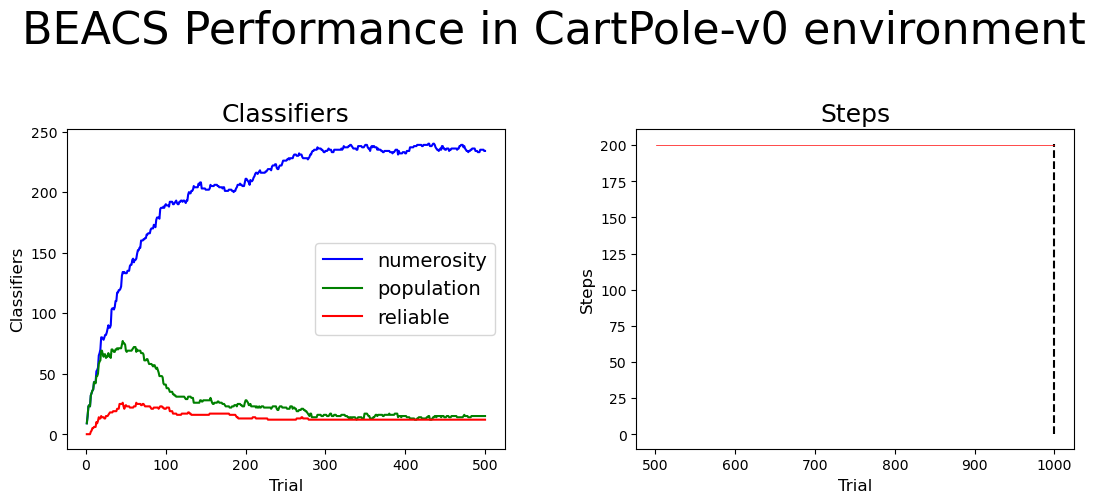

In [10]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit_rl, metrics_trial_frequency_exploit)
plot_cartpole_performance(agent_exploit_rl, CartPole, metrics_df, cfg_exploit_rl, CARTPOLE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_RL])

In [11]:
trials=[]

avg_step_explore = 0
for trial in metrics_explore:
    trials.append(trial['steps_in_trial'])
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the cartpole is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

if NUMBER_OF_EXPLOIT_TRIALS_RL:
    avg_step_exploit_rl = 0
    for trial in metrics_exploit_rl:
        trials.append(trial['steps_in_trial'])
        avg_step_exploit_rl += trial['steps_in_trial']
    avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
    print("Average number of steps to solve the cartpole is ",avg_step_exploit_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_cartpole_metrics(population_explore, CartPole))
print(_cartpole_metrics(population_exploit_rl, CartPole))

Average number of steps to solve the cartpole is  24.594  for a total of  500  trials in EXPLORATION
Average number of steps to solve the cartpole is  200.0  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'population': 15, 'numerosity': 234, 'reliable': 12}
{'population': 15, 'numerosity': 234, 'reliable': 12}


Solved requirements at episode 599 : average 196.88 for 100 episodes


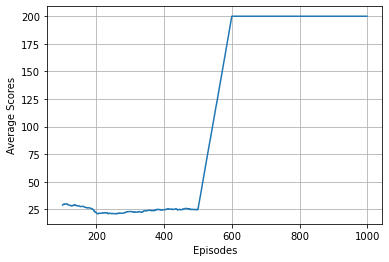

In [12]:
plot_average_cartpole_performance(trials)

In [13]:
# population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence or cl.is_enhanced()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display[:5]:
    print(cl)
    print("\n")

11


##12 0 None (####:239, ##2#:115)
q: 1.0    ra: 11.42  rb: 11.6   ir: 1.0    f: 11.6   err: 1.151 
exp: 265   num: 17 ee: False
Mark: empty Aliased_state: 0012 PAI_state: 
tga: 12244 tbseq: 301   talp: 12286 tav: 34.67  



##21 0 None (####:955, ###2:464, ##1#:28)
q: 1.0    ra: 12.42  rb: 12.47  ir: 1.0    f: 12.47  err: 1.135 
exp: 1370  num: 20 ee: False
Mark: empty Aliased_state: 0021 PAI_state: 
tga: 12271 tbseq: 461   talp: 12291 tav: 6.825  



##20 0 None (##11:69, ##1#:85, ###1:141, ####:144)
q: 1.0    ra: 18.39  rb: 18.36  ir: 1.0    f: 18.39  err: 0.1311
exp: 202   num: 19 ee: False
Mark: empty Aliased_state: 0020 PAI_state: 
tga: 12071 tbseq: 706   talp: 12071 tav: 53.85  



##12 1 None (###1:160, ####:106, ##21:33, ##2#:42)
q: 1.0    ra: 18.31  rb: 17.43  ir: 1.0    f: 18.31  err: 1.062 
exp: 290   num: 20 ee: False
Mark: empty Aliased_state: 0012 PAI_state: 
tga: 12245 tbseq: 809   talp: 12253 tav: 32.19  



##10 0 None (###1:483, ####:833, ##2#:40)
q: 1.0    ra: 18